### Problem 1 (50 points) 

Vapor-liquid equilibria data are correlated using two adjustable parameters $A_{12}$ and $A_{21}$ per binary
mixture. For low pressures, the equilibrium relation can be formulated as:

$$
\begin{aligned}
p = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

Here the saturation pressures are given by the Antoine equation

$$
\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3},
$$

where $T = 20$($^{\circ}{\rm C}$) and $a_{1,2,3}$ for a water - 1,4 dioxane
system is given below.

|             | $a_1$     | $a_2$      | $a_3$     |
|:------------|:--------|:---------|:--------|
| Water       | 8.07131 | 1730.63  | 233.426 |
| 1,4 dioxane | 7.43155 | 1554.679 | 240.337 |


The following table lists the measured data. Recall that in a binary system $x_1 + x_2 = 1$.

|$x_1$ | 0.0 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
|:-----|:--------|:---------|:--------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|
|$p$| 28.1 | 34.4 | 36.7 | 36.9 | 36.8 | 36.7 | 36.5 | 35.4 | 32.9 | 27.7 | 17.5 |

Estimate $A_{12}$ and $A_{21}$ using data from the above table: 

1. Formulate the least square problem; 
2. Since the model is nonlinear, the problem does not have an analytical solution. Therefore, solve it using the gradient descent or Newton's method implemented in HW1; 
3. Compare your optimized model with the data. Does your model fit well with the data?

---

### Problem 2 (50 points) 

Solve the following problem using Bayesian Optimization:
$$
    \min_{x_1, x_2} \quad \left(4-2.1x_1^2 + \frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + \left(-4 + 4x_2^2\right)x_2^2,
$$
for $x_1 \in [-3,3]$ and $x_2 \in [-2,2]$. A tutorial on Bayesian Optimization can be found [here](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).





/home/rrathnak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/rrathnak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
No handles with labels found to put in legend.


Model:  [43.93416584 44.76621157 44.37621867 43.82159661 43.50080095 43.43928818
 43.34240011 42.45983259 39.19505613 30.24392356  8.76035439]
Truth:  [28.1 34.4 36.7 36.9 36.8 36.7 36.5 35.4 32.9 27.7 17.5]
Alpha: 0.000125 Loss: 774.4710814131502 Gradient: [853.41111947 463.29415841] Parameter: [2. 2.]
Alpha: 0.00025 Loss: 668.9434365890725 Gradient: [702.8285649 320.9153932] Parameter: [1.89332361 1.94208823]
Alpha: 0.00025 Loss: 546.8403540325007 Gradient: [483.36113386 138.62163528] Parameter: [1.71761647 1.86185938]
Alpha: 0.00025 Loss: 493.21642072862375 Gradient: [351.16764354  49.25817269] Parameter: [1.59677619 1.82720397]
Alpha: 0.00025 Loss: 466.0343243151742 Gradient: [260.8662053    0.48283756] Parameter: [1.50898427 1.81488943]
Alpha: 0.00025 Loss: 451.1350109966272 Gradient: [195.67472315 -27.32501212] Parameter: [1.44376772 1.81476872]
Alpha: 0.00025 Loss: 442.4899040361789 Gradient: [147.52290966 -43.3108709 ] Parameter: [1.39484904 1.82159997]
Alpha: 0.0005 Loss: 437.

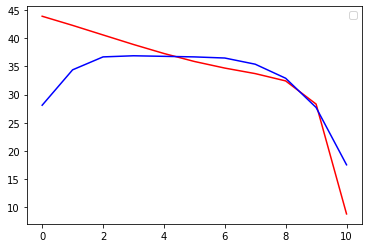

In [55]:
# Problem 1 : Least squares fitting for vapor-liquid equilibrium
import torch
import numpy as np
import matplotlib.pyplot as plt


def model(X, A, p_sat):
    p1 = A[0]*X[0]
    p2 = A[1]*X[1]
    sum = p1 + p2
    k1 = A[0]*((p2/sum)**2)
    k2 = A[1]*((p1/sum)**2)
    t1 = X[0]*torch.exp(k1)*p_sat[0]
    t2 = X[1]*torch.exp(k2)*p_sat[1]
    return t1 + t2

# Define the variables to be optimized over
A = torch.tensor([2.0,2.0], requires_grad = True, dtype = torch.float64)
# Data
X = np.asarray([np.arange(0,1.1,0.1), 1-np.arange(0,1.1,0.1)])
X = torch.from_numpy(X)
p = torch.tensor([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5], requires_grad =  False, dtype = torch.float64)
# Constants
a = torch.tensor([[8.07131, 1730.63, 233.426],[7.43155, 1554.679, 240.337]], requires_grad= False)
T = 20
p_sat_water = torch.tensor(a[0][0] - (a[0][1]/(T + a[0][2])))
p_sat_dioxane = torch.tensor(a[1][0] - (a[1][1]/(T + a[1][2])))
p_sat = torch.pow(torch.tensor([p_sat_water, p_sat_dioxane], requires_grad = False, dtype = torch.float64),10)

print("Model: ", model(X,A,p_sat).detach().numpy())
print("Truth: ", p.detach().numpy())

def phi(alpha,p, A):
    return np.sum((p - model(X, A, p_sat)).detach().numpy()**2) - alpha*0.8*np.dot(A.grad, A.grad)

def line_search(X, p, A, p_sat):
    alpha = 0.001  # initialize step size
    while phi(alpha, p, A)<np.sum((p - model(X, A-alpha*A.grad, p_sat)).detach().numpy()**2):  # if f(x+a*d)>phi(a) then backtrack. d is the search direction
        alpha = 0.5*alpha
    return alpha
n_iter = 1000
for i in range(n_iter):
    # Define the loss function
    loss = torch.sum((p - model(X, A, p_sat))**2)
    loss.backward()
    alpha = line_search(X = X, p = p, A = A, p_sat = p_sat)
    print("Alpha:", alpha, "Loss:", loss.data.numpy(), "Gradient:", A.grad.numpy(), "Parameter:", A.data.numpy())

    with torch.no_grad():
        A -= alpha * A.grad
        if np.linalg.norm(A.grad) < 0.001:
            break
        A.grad.zero_()
p_final = model(X, A, p_sat)
print("Model: ", p_final)
print("Truth: ", p)
plt.plot(p_final.detach().numpy(), 'red')
plt.plot(p.detach().numpy(), 'blue')
plt.legend()




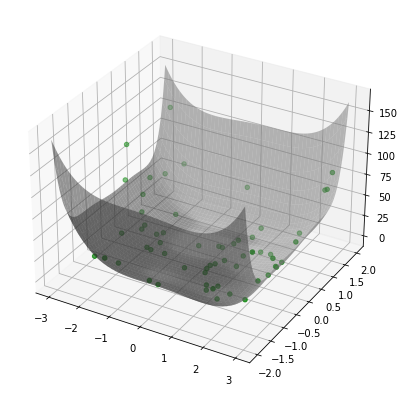

In [4]:
# Problem 2: Bayesian Optimization
import sklearn.gaussian_process as gp
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d


def objective(x):
    '''
    x : 2x1 vector of a sample in the domain of interest
    mean : scalar mean for iid noise term
    var : scalar variance for iid noise term
    '''
    return ((4 - (2.1*(x[0]**2)) + ((x[0]**4)/3))*(x[0]**2)) + (x[0]*x[1]) + ((-4 + 4*x[1]**2)*x[1]**2)



def expected_improvement(X_, X, model, k = 0.01):
    Y_mu, Y_sigma = model.predict(X, return_std = True)
    Y__= model.predict(X_)
    
    # Find the best value of predicted f(x) among the old samples
    with np.errstate(divide='ignore'):
        y_best = np.max(Y_sigma)
        Z = (Y_mu - y_best - k)/Y_sigma
        ei = ((Y_mu - y_best - k)*norm.cdf(Z)) + (Y_sigma*norm.pdf(Z))
        ei[Y_sigma == 0.0] = 0.0
    return X_[np.argmax(ei)]


# optimize the expected improvement
# EI function is highly non convex
x1 = np.random.uniform(-3,3,10)
x2 = np.random.uniform(-2,2,10)
X = np.asarray([[x1],[x2]]).transpose().squeeze(1)
Y = np.asarray([objective(x) for x in X])

kernel = gp.kernels.Matern()
model = gp.GaussianProcessRegressor(kernel=kernel,
                                    alpha=1e-4,
                                    n_restarts_optimizer=0,
                                    normalize_y=True)
n_iters = 20
k = 0.01
for i in range(n_iters):
    model.fit(X,Y)
    # Select next point using expected improvement
    x1 = np.random.uniform(-3,3,1000)
    x2 = np.random.uniform(-2,2,1000)
    X_ = np.asarray([[x1],[x2]]).transpose().squeeze(1)
    x_next = expected_improvement(X_ = X_, X = X, model = model)
    y_next = objective(x_next)
    X = np.vstack((X, x_next))
    Y = np.append(Y, y_next)

x1_bnds = np.linspace(-3,3, 100)
x2_bnds = np.linspace(-2, 2, 100)
x_pts, y_pts= np.meshgrid(x1_bnds, x2_bnds)
pts = np.asarray([x_pts,y_pts]).transpose()
z__ = np.asarray([[objective(pt) for pt in pt_set] for pt_set in pts])



fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X[:,0], X[:,1], Y, color = "green")
ax.plot_surface(x_pts, y_pts, z__, color='gray', alpha = 0.5)
plt.show()